# ATIAM FpA computer science

## Assignment

This script defines the overall exercise for ATIAM structure course

 - Use this as a baseline script
 - You are authorized to define other files for functions
 - Write a (small) report document (PDF) explaining your approach
 - All your files should be packed in a zip file named
     [ATIAM][FpA2020]FirstName_LastName.zip

@author: esling

In [1]:
%load_ext autoreload
%autoreload 2
from typing import Any, Callable, Union
import importlib
import util as ut
# importlib.reload(ut)

# Basic set of imports (here you can see if everything passes)
from music21 import converter
import numpy as np
import math
from needleman import needleman_affine
from needleman import needleman_simple
import string
import pickle
import os
import pretty_midi as midi
import re
import matplotlib.pyplot as plt


('CEELECANTH', '-PELICAN--', 13)


In [2]:
unit_testing = True
unit_testing_log_level = 2


midi_database = pickle.load(open("atiam-fpa.pkl", "rb"))
composers = midi_database['composers']
composers_tracks = midi_database['composers_tracks']

# Here an example: print all composers with more than 10 tracks
for composer, tracks in sorted(composers_tracks.items()):
    if (len(tracks) >= 10):
        print(f"{composer} :  {len(tracks)} tracks")

Abel, Carl Friedrich :  27 tracks
Aboyan, Gayk :  554 tracks
Abt, Franz :  38 tracks
Adam, Adolphe :  11 tracks
Adson, John :  71 tracks
Agincour, François d' :  15 tracks
Agrell, Johan :  84 tracks
Agricola, Alexander :  12 tracks
Aguado, Dionisio :  28 tracks
Ahle, Johann Rudolf :  18 tracks
Aiblinger, Johann Kaspar :  18 tracks
Aichinger, Gregor :  12 tracks
Alain, Jehan :  13 tracks
Albeniz, Isaac :  49 tracks
Albert, Heinrich :  10 tracks
Albinoni, Tomaso :  170 tracks
Albrechtsberger, Johann Georg :  89 tracks
Aleotti, Vittoria :  18 tracks
Alexandra, Liana :  12 tracks
Alink, Bert :  22 tracks
Alkan, Charles-Valentin :  30 tracks
Allegri, Lorenzo :  12 tracks
Allison, Richard :  177 tracks
Alsen, Wulf Dieter :  38 tracks
Altenburg, Johann Ernst :  28 tracks
Altenburg, Michael :  26 tracks
Alıcıoğlu, Şafak :  75 tracks
Ammer, Manfred :  114 tracks
Anderson, Leigh :  10 tracks
André, Johann Anton :  11 tracks
Anglebert :  67 tracks
Anonymous :  27 tracks
Anonymus, .... :  899 

### PART 1 - Exploring a track collections (text dictionnaries) and playing with MIDI

In this part, we will start easy by looking at a collection of tracks.
The set of classical music pieces is provided in the _atiam-fpa.pkl_ file, which
is already loaded at this point of the script and contain two structures
    - composers         = Array of all composers in the database
    - composers_tracks  = Hashtable of tracks for a given composer


### Q-1.2 Use your own algorithm to sort the collection of composers by decreasing number of tracks

In [3]:
## Some unit testing
use_threads = False
if unit_testing:
    rng = np.random.default_rng()
    for i in range(100):
        dim = rng.integers(1, 4)
        shape=tuple(rng.integers(1, 20, size=dim))
        n = np.multiply.reduce(shape)
        axis=rng.integers(0, dim)
        if unit_testing_log_level <= 1:
            print(f"shape={shape}, axis={axis}")
        arr = rng.integers(0, n, size=n)
        rng.shuffle(arr)
        arr = arr.reshape(shape)
        arr_sorted_truth = np.sort(arr, axis=axis)
        #
        arr_sorted = ut.pipsorted(arr, axis=axis, use_threads=use_threads)
        #
        if unit_testing_log_level <= 2 and np.linalg.norm(arr_sorted-arr_sorted_truth)>0.001:
            print("-- ERROR --")
            print(f"expected:  {arr_sorted_truth}")
            print(f"got:       {arr_sorted}")

In [29]:
# see: https://stackoverflow.com/q/15579649
# and: https://stackoverflow.com/a/43187340
composers_tracks_tuple = np.array([(comp, composers_tracks[comp] if comp in composers_tracks else []) for comp in composers], dtype=object)

composers_tracks_tuple_sorted = ut.pipsorted(composers_tracks_tuple, axis=0, order=lambda a, b: len(a[1])-len(b[1]), way='below')[::-1]
composers_tracks_sorted = dict(np.copy(composers_tracks_tuple_sorted))
for composer, tracks in composers_tracks_sorted.items():
    if len(tracks) > 0:
        print(f"Composer: {composer}, # of tracks={len(tracks)}")

Composer: Rondeau, Michel, # of tracks=2720
Composer: Gouin, Pierre, # of tracks=2333
Composer: Knuth, Jürgen, # of tracks=1641
Composer: Bach, Johann Sebastian, # of tracks=1463
Composer: Mozart, Wolfgang Amadeus, # of tracks=1250
Composer: Schubert, Franz, # of tracks=1083
Composer: Bach, August Wilhelm, # of tracks=1004
Composer: Handel, George Frideric, # of tracks=906
Composer: Anonymus, ...., # of tracks=899
Composer: Beethoven, Ludwig van, # of tracks=801
Composer: Scarlatti, Alessandro, # of tracks=731
Composer: Praetorius, Michael, # of tracks=708
Composer: Haydn, Joseph, # of tracks=650
Composer: Mondrup, Christian, # of tracks=631
Composer: Brahms, Johannes, # of tracks=618
Composer: Guilmant, Alexandre, # of tracks=594
Composer: Schütz, Heinrich, # of tracks=558
Composer: Aboyan, Gayk, # of tracks=554
Composer: Brodersen, Fritz, # of tracks=544
Composer: Telemann, Georg Philipp, # of tracks=541
Composer: Schumann, Robert, # of tracks=536
Composer: Upton, Dillon, # of trac

### Q-1.3 Extend your sorting procedure, to sort all tracks from all composers alphabetically

In [30]:
def lexi_comp(a: str, b: str) -> int:
    # print(a, b)
    i = 0
    while i < min(len(a), len(b)):
        if a[i] > b[i]:
            return 1
        elif a[i] < b[i]:
            return -1
        i += 1
    if len(a) > len(b):
        return 1
    elif len(a) < len(b):
        return -1
    return 0

tracks_sorted = np.empty_like(composers_tracks_tuple_sorted[:, 1])
for i in range(composers_tracks_tuple_sorted.shape[0]):
    tracks_sorted[i] = ut.pipsorted(composers_tracks_tuple_sorted[i, 1], order=lambda a, b: lexi_comp(a, b))
composers_tracks_sorted_2 = dict([(composers[i], tracks_sorted[i]) for i in range(len(tracks_sorted))])
for composer, tracks in composers_tracks_sorted_2.items():
   if len(tracks) > 0:
       print(f"Composer: {composer}, #={len(tracks)} -- {tracks[::len(tracks)//5+1]}")

Composer: Walond, William, #=2720 -- ['10 Piano Sonatinas ' 'Ariadne Musica (Fischer, Johann Caspar Ferdinand)'
 'Fugue in G minor (Murschhauser, Franz Xaver)'
 'Pièces de clavecin avec une méthode (Rameau, Jean-Philippe)'
 'The Whole Booke of Psalmes (Ravenscroft, Thomas)']
Composer: Zinkeisen, Konrad Ludwig Dietrich, #=2333 -- ['10 Pieces for the Virginals or Organ (Anonymous)'
 'Annuaire de l’Organiste (Lasceux, Guillaume)'
 'Flötenuhrstücke, Hob.XIX:1-32 (Haydn, Joseph)'
 'Music for the Royal Fireworks, HWV 351 (Handel, George Frideric)'
 "Pièces de clavecin (Agincour, François d')"]
Composer: Kalinnikov, Viktor, #=1641 -- ['12 Deutsche Volkslieder, WoO 35 (Brahms, Johannes)'
 'Allegro in C major (Hässler, Johann Wilhelm)'
 'Chorale Preludes, BWV 714-765 (Bach, Johann Sebastian)'
 'Laut verkünde unsre Freude, K.623 (Mozart, Wolfgang Amadeus)'
 "Pièces d'Orgue pour le Magnificat (Guilain, Jean-Adam)"]
Composer: Ackerman, Daryle Stephen, #=1463 -- ['"Air on the G String" fro

## MIDI part 

### In addition to the pickle file, you can find some example MIDI files in the atiam-fpa/ folder.

### Here we are going to import and plot the different MIDI files. We recommend using the pretty_midi library

    pip install pretty_midi

### But you can rely on any method (even code your own if you want)


### Q-1.4 Import and plot some MIDI files

### Based on the provided MIDI files (random subset of Beethoven tracks), try to import, plot and compare different files.

/home/xabbu/anaconda3/envs/env_info/lib/python3.7/site-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


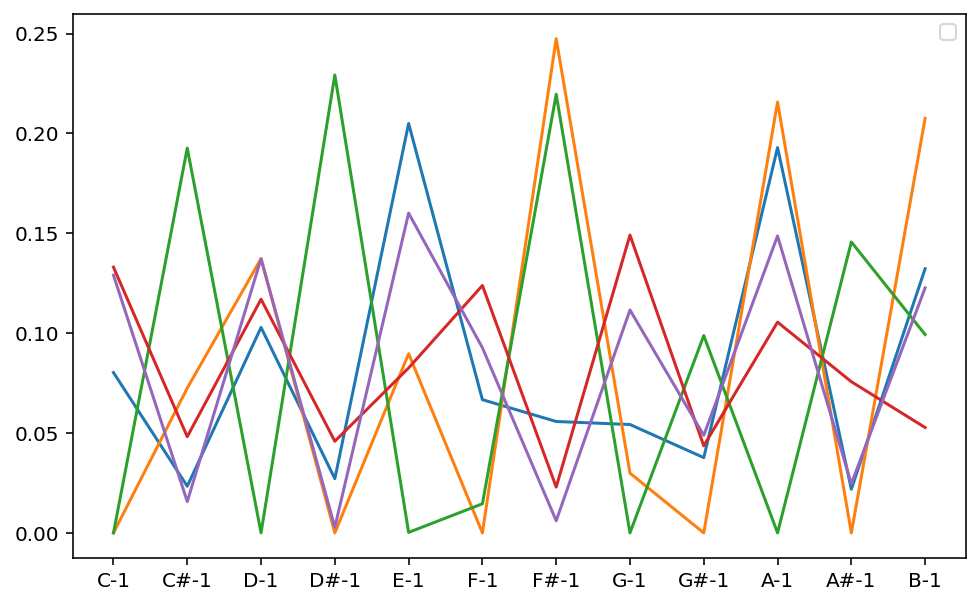

In [35]:
# midi_dir = './atiam-fpa/'
# pat = 'beethoven_[0-9]*.[mid|midi|MID|MIDI]'
midi_dir = './partitions/'
pat = r'[a-zA-Z_]*\.[mid|midi|MID|MIDI]'

files = [os.path.abspath(os.path.join(midi_dir, x)) for x in os.listdir(midi_dir) if re.match(pat, x)]
get_part_name = lambda f: os.path.splitext(os.path.basename(f))[0]
parts = np.array([(get_part_name(file), midi.PrettyMIDI(file)) for file in files], dtype=[('name', 'U20'), ('midi', midi.PrettyMIDI)])
get_key_name = np.vectorize(lambda i: midi.key_number_to_key_name(i))
get_note_name = np.vectorize(lambda i: midi.note_number_to_name(i))

fig = plt.figure('Pitch class histrogrammes', figsize=(8, 5))
axis = fig.add_subplot()
axis.legend(parts['name'])
for (i, part) in enumerate(parts):
    notes = get_note_name(np.arange(12))
    axis.plot(notes, part['midi'].get_pitch_class_histogram()) 

### Q-1.5 Compute the number of notes in a MIDI and sort the collection

### First write a function counting the number of notes played in a given MIDI file.
### Then, sort the set of MIDI files based on the number of notes.

In [204]:
def count_notes(m: midi.PrettyMIDI):
    # see: https://stackoverflow.com/a/42889025
    larr = np.array([len(l) for l in ut.get_instrument_notes(m).values()])
    return np.sum(larr, axis=None)

parts_sorted = ut.pipsorted(parts, axis=0, order=lambda p1, p2: count_notes(p1['midi']) - count_notes(p2['midi'])) 
for part in parts_sorted:
    print(f" Song: {part['name']}, # of notes: {count_notes(part['midi'])}")


 Song: pastorale_satie, # of notes: 436
 Song: foggy_trad, # of notes: 1815
 Song: anitras_grieg, # of notes: 2714
 Song: manha_bonfa, # of notes: 3312
 Song: tonight_smashing, # of notes: 6108


### PART 2 - Symbolic alignments and simple text dictionaries

In this part, we will use our knowledge on computer structures to solve a very
well-known problem of string alignment. Hence, this part is split between:

1) Implement a string alignment
2) Try to apply this to a collection of classical music pieces names
3) Develop your own more adapted procedure to have a matching inside large set

The set of classical music pieces is provided in the atiam-fpa.pkl file, which
is already loaded at this point of the script and contain two structures
- `composers`         = Array of all composers in the database
- `composers_tracks`  = Hashtable of tracks for a given composer

Some examples of the content of these structures

    composers[23] => 'Abela, Placido'
    composers[1210]  => 'Beethoven, Ludwig van'

    composers_tracks['Abela, Placido'] => ['Ave Maria(Meditation on Prelude No. 1 by J.S.Bach)']
    composers_tracks['Beethoven, Ludwig van'] => ['"Ode to Joy"  (Arrang.)', '10 National Airs with Variations, Op.107 ', ...]

    composers_tracks['Beethoven, Ludwig van'][0] => '"Ode to Joy"  (Arrang.)'

### Question 1 - Reimplementing the simple NW alignment

### Q-2.1 Here perform your Needleman-Wunsch (NW) implementation.

- You can find the definition of the basic NW here
    https://en.wikipedia.org/wiki/Needleman%E2%80%93Wunsch_algorithm
    - In this first version, we will be implementing the _basic_ gap costs
    - Remember to rely on a user-defined matrix for symbols distance


In [39]:

f_1 = './atiam-fpa_alpha.dist'
f_2 = './atiam-fpa_dna.dist'
letters, sim_mat = ut.load_similarity_matrix(f_1)
s_1 = "CEELECANTH"
s_2 = "PELICAN"
gap_penality=-2
# Exemple d'utilisation
if unit_testing:
    aligned_2 = needleman_simple(s_1, s_2,  matrix=f_1, gap=gap_penality)
    if unit_testing_log_level <= 2:
        print('Results for basic gap costs (linear)')
        print(aligned_2[0])
        print(aligned_2[1])
        print(f"Score={aligned_2[2]}")
    path_mat, grad_mat = ut.get_path_matrices(s_1, s_2, sim_mat, letters, gap_penalty=gap_penality)
    aligned, score = ut.get_aligned_strings(s_1, s_2, path_mat, grad_mat)
    # print(aligned)
    if unit_testing_log_level <= 2:
        print('Pip -- Results for basic gap costs (linear)')
        print(f"Score={score}")
        print("Paths:")
        for i in range(len(aligned)):
            print(f"{i}: {aligned[i][0]} -- {aligned[i][1]}")

Results for basic gap costs (linear)
CEELECANTH
-PELICAN--
Score=13
Pip -- Results for basic gap costs (linear)
Score=13
Paths:
0: CEELECANTH -- -PELICAN--
1: CEELECANTH -- P-ELICAN--
2: CEELECANTH -- PE-LICAN--


[(0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
